# 09. PyTorch Model Deployment Exercise Solutions

## Resources

These exercises are based on https://www.learnpytorch.io/09_pytorch_model_deployment/ of the Learn PyTorch for Deep Learning course by Zero to Mastery

### Get various imports and helper functions

In [1]:
import torch
import torchvision
print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")

torch version: 2.7.1+cu126
torchvision version: 0.22.1+cu126


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

from torchinfo import summary

from src import setup_data, engine
from src.helper_functions import download_data, set_seeds, plot_loss_curves

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Get data

Want to download the data we've been using in PyTorch Model Deployment: https://www.learnpytorch.io/09_pytorch_model_deployment/#1-getting-data

In [4]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                           destination="pizza_steak_sushi_20_percent")
image_path

[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_steak_sushi_20_percent')

In [5]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

### Preprocess data

In [6]:
# Create image size (from Table 3 in the ViT paper) 
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])           
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [7]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = setup_data.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x76be18d0bf10>,
 ['pizza', 'steak', 'sushi'])

In [8]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(2))

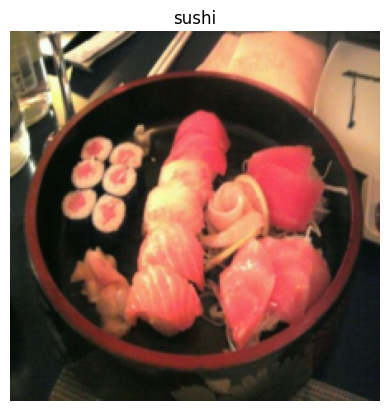

In [9]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

## Exercise 1. Make and time predictions with both feature extractor models on the test dataset using the GPU (`device="cuda"`). 

* Compare the model's prediction times on GPU vs CPU - does this close the gap between them? As in, does making predictions on the GPU make the ViT feature extractor prediction times closer to the EffNetB2 feature extractor prediction times?
* You'll find code to do these steps in [section 5. Making predictions with our trained models and timing them](https://www.learnpytorch.io/09_pytorch_model_deployment/#5-making-predictions-with-our-trained-models-and-timing-them) and [section 6. Comparing model results, prediction times and size](https://www.learnpytorch.io/09_pytorch_model_deployment/#6-comparing-model-results-prediction-times-and-size).

### EffNetB2 

In [15]:
def create_effnetb2_model(num_classes:int=3, 
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head. 
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model. 
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # 1, 2, 3. Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights).to(device)

    # 4. Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # 5. Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    ).to(device)
    
    return model, transforms

In [16]:
effnetb2, effnetb2_transforms = create_effnetb2_model()
# effnetb2
effnetb2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [17]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

In [18]:
# Create dataloaders for EffNetB2 
BATCH_SIZE = 32
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = setup_data.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnetb2_transforms,
                                                                                                 batch_size=BATCH_SIZE)

len(train_dataloader_effnetb2), len(test_dataloader_effnetb2), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

In [19]:
# Train EffNetB2 feature extractor
from src import engine

optimizer = torch.optim.Adam(params=effnetb2.parameters(), lr=1e-3)

loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()
effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                epochs=10,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9843 | train_acc: 0.5667 | test_loss: 0.7410 | test_acc: 0.9347
Epoch: 2 | train_loss: 0.7171 | train_acc: 0.8396 | test_loss: 0.5877 | test_acc: 0.9409
Epoch: 3 | train_loss: 0.5878 | train_acc: 0.8938 | test_loss: 0.4901 | test_acc: 0.9563
Epoch: 4 | train_loss: 0.4481 | train_acc: 0.9125 | test_loss: 0.4349 | test_acc: 0.9409
Epoch: 5 | train_loss: 0.4302 | train_acc: 0.9062 | test_loss: 0.3921 | test_acc: 0.9443
Epoch: 6 | train_loss: 0.4400 | train_acc: 0.8875 | test_loss: 0.3523 | test_acc: 0.9597
Epoch: 7 | train_loss: 0.4253 | train_acc: 0.8792 | test_loss: 0.3267 | test_acc: 0.9563
Epoch: 8 | train_loss: 0.3900 | train_acc: 0.8979 | test_loss: 0.3461 | test_acc: 0.9352
Epoch: 9 | train_loss: 0.3769 | train_acc: 0.8771 | test_loss: 0.3130 | test_acc: 0.9131
Epoch: 10 | train_loss: 0.3769 | train_acc: 0.8625 | test_loss: 0.2814 | test_acc: 0.9688


In [ ]:
# With label_smoothing=0.1
# Epoch: 1 | train_loss: 1.0005 | train_acc: 0.5708 | test_loss: 0.7872 | test_acc: 0.9347
# Epoch: 2 | train_loss: 0.7704 | train_acc: 0.8500 | test_loss: 0.6603 | test_acc: 0.9409
# Epoch: 3 | train_loss: 0.6679 | train_acc: 0.8896 | test_loss: 0.5883 | test_acc: 0.9500
# Epoch: 4 | train_loss: 0.5608 | train_acc: 0.9146 | test_loss: 0.5522 | test_acc: 0.9318
# Epoch: 5 | train_loss: 0.5528 | train_acc: 0.9125 | test_loss: 0.5239 | test_acc: 0.9352
# Epoch: 6 | train_loss: 0.5718 | train_acc: 0.8875 | test_loss: 0.4973 | test_acc: 0.9597
# Epoch: 7 | train_loss: 0.5609 | train_acc: 0.8854 | test_loss: 0.4864 | test_acc: 0.9472
# Epoch: 8 | train_loss: 0.5457 | train_acc: 0.8958 | test_loss: 0.5050 | test_acc: 0.9318
# Epoch: 9 | train_loss: 0.5338 | train_acc: 0.8896 | test_loss: 0.4809 | test_acc: 0.9193
# Epoch: 10 | train_loss: 0.5417 | train_acc: 0.8500 | test_loss: 0.4654 | test_acc: 0.9625

# Without label_smoothing=0.1
# Epoch: 1 | train_loss: 0.9856 | train_acc: 0.5604 | test_loss: 0.7408 | test_acc: 0.9347
# Epoch: 2 | train_loss: 0.7175 | train_acc: 0.8438 | test_loss: 0.5869 | test_acc: 0.9409
# Epoch: 3 | train_loss: 0.5876 | train_acc: 0.8917 | test_loss: 0.4909 | test_acc: 0.9500
# Epoch: 4 | train_loss: 0.4474 | train_acc: 0.9062 | test_loss: 0.4355 | test_acc: 0.9409
# Epoch: 5 | train_loss: 0.4290 | train_acc: 0.9104 | test_loss: 0.3915 | test_acc: 0.9443
# Epoch: 6 | train_loss: 0.4381 | train_acc: 0.8896 | test_loss: 0.3512 | test_acc: 0.9688
# Epoch: 7 | train_loss: 0.4245 | train_acc: 0.8771 | test_loss: 0.3268 | test_acc: 0.9563
# Epoch: 8 | train_loss: 0.3897 | train_acc: 0.8958 | test_loss: 0.3457 | test_acc: 0.9381
# Epoch: 9 | train_loss: 0.3749 | train_acc: 0.8812 | test_loss: 0.3129 | test_acc: 0.9131
# Epoch: 10 | train_loss: 0.3757 | train_acc: 0.8604 | test_loss: 0.2813 | test_acc: 0.9688

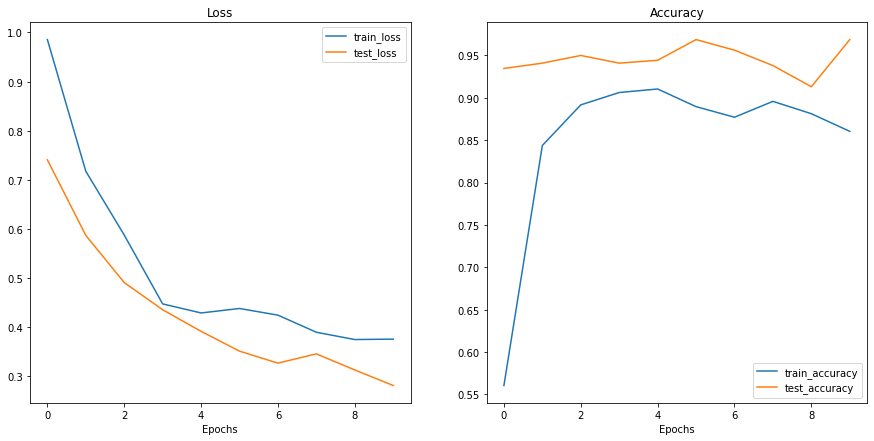

In [ ]:
plot_loss_curves(effnetb2_results)

### Preparing and training ViT feature extractor

In [20]:
def create_vit_model(num_classes:int=3, 
                     seed:int=42):
    """Creates a ViT-B/16 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of target classes. Defaults to 3.
        seed (int, optional): random seed value for output layer. Defaults to 42.

    Returns:
        model (torch.nn.Module): ViT-B/16 feature extractor model. 
        transforms (torchvision.transforms): ViT-B/16 image transforms.
    """
    # Create ViT_B_16 pretrained weights, transforms and model
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights).to(device)

    # Freeze all layers in model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head to suit our needs (this will be trainable)
    torch.manual_seed(seed)
    model.heads = nn.Sequential(nn.Linear(in_features=768, # keep this the same as original model
                                          out_features=num_classes)).to(device) # update to reflect target number of classes
    
    return model, transforms

In [21]:
vit, vit_transforms = create_vit_model()
# vit
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [22]:
# Create dataloaders for ViT
BATCH_SIZE = 32
train_dataloader_vit, test_dataloader_vit, class_names = setup_data.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=vit_transforms,
                                                                                                 batch_size=BATCH_SIZE)

len(train_dataloader_vit), len(test_dataloader_vit), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

In [23]:
# Train ViT feature extractor
optimizer = torch.optim.Adam(params=vit.parameters(), lr=1e-3)

loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()
vit_results = engine.train(model=vit,
                                train_dataloader=train_dataloader_vit,
                                test_dataloader=test_dataloader_vit,
                                epochs=10,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7020 | train_acc: 0.7521 | test_loss: 0.2714 | test_acc: 0.9381
Epoch: 2 | train_loss: 0.2532 | train_acc: 0.9062 | test_loss: 0.1672 | test_acc: 0.9602
Epoch: 3 | train_loss: 0.1764 | train_acc: 0.9542 | test_loss: 0.1273 | test_acc: 0.9693
Epoch: 4 | train_loss: 0.1276 | train_acc: 0.9625 | test_loss: 0.1074 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1159 | train_acc: 0.9646 | test_loss: 0.0953 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.1273 | train_acc: 0.9375 | test_loss: 0.0832 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0897 | train_acc: 0.9771 | test_loss: 0.0845 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.0919 | train_acc: 0.9812 | test_loss: 0.0764 | test_acc: 0.9722
Epoch: 9 | train_loss: 0.0922 | train_acc: 0.9792 | test_loss: 0.0734 | test_acc: 0.9784
Epoch: 10 | train_loss: 0.0658 | train_acc: 0.9833 | test_loss: 0.0644 | test_acc: 0.9847


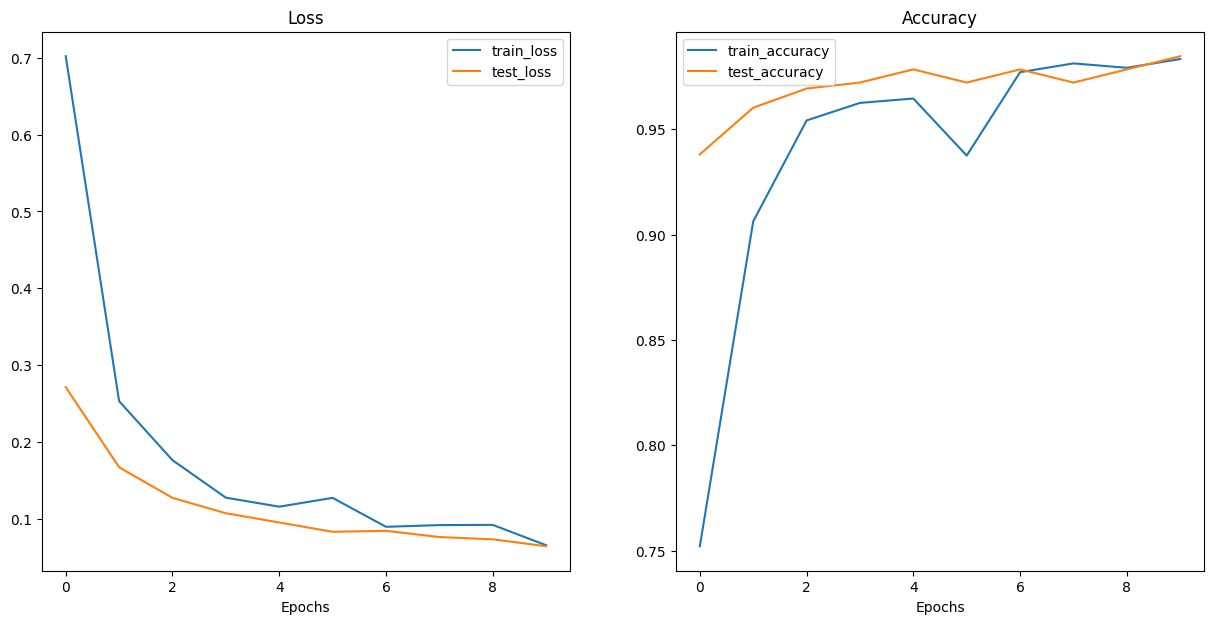

In [24]:
plot_loss_curves(vit_results)

### Get all the images from the test path

Want to make predictions acrosss the test dataset images and time them on GPU to see if they're faster on GPU or CPU...

In [25]:
from pathlib import Path
test_image_paths = list(Path(test_dir).glob("*/*.jpg"))
len(test_image_paths)

150

In [26]:
test_image_paths[:5]

[PosixPath('data/pizza_steak_sushi_20_percent/test/steak/40947.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/413497.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/3479599.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/3063435.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1848936.jpg')]

### Get function for making predictions and timing them

In [27]:
class_names

['pizza', 'steak', 'sushi']

In [28]:
"cuda" if torch.cuda.is_available() else "cpu"

'cuda'

In [29]:
import pathlib
import torch

from PIL import Image
from timeit import default_timer as timer 
from tqdm.auto import tqdm
from typing import List, Dict

# 1. Create a function to return a list of dictionaries with sample, truth label, prediction, prediction probability and prediction time
def pred_and_store(paths: List[pathlib.Path], 
                   model: torch.nn.Module,
                   transform: torchvision.transforms, 
                   class_names: List[str], 
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:
    
    # 2. Create an empty list to store prediction dictionaires
    pred_list = []
    
    # 3. Loop through target paths
    for path in tqdm(paths):
        
        # 4. Create empty dictionary to store prediction information for each sample
        pred_dict = {}

        # 5. Get the sample path and ground truth class name
        pred_dict["image_path"] = path
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name
        
        # 6. Start the prediction timer
        start_time = timer()
        
        # 7. Open image path
        img = Image.open(path)
        
        # 8. Transform the image, add batch dimension and put image on target device
        transformed_image = transform(img).unsqueeze(0).to(device) 
        
        # 9. Prepare model for inference by sending it to target device and turning on eval() mode
        model = model.to(device)
        model.eval()
        
        # 10. Get prediction probability, predicition label and prediction class
        with torch.inference_mode():
            pred_logit = model(transformed_image) # perform inference on target sample 
            pred_prob = torch.softmax(pred_logit, dim=1) # turn logits into prediction probabilities
            pred_label = torch.argmax(pred_prob, dim=1) # turn prediction probabilities into prediction label
            pred_class = class_names[pred_label.cpu()] # hardcode prediction class to be on CPU

            # 11. Make sure things in the dictionary are on CPU (required for inspecting predictions later on) 
            pred_dict["pred_prob"] = round(pred_prob.max().cpu().item(), 4)
            pred_dict["pred_class"] = pred_class
            
            # 12. End the timer and calculate time per pred
            end_time = timer()
            pred_dict["time_for_pred"] = round(end_time-start_time, 4)

        # 13. Does the pred match the true label?
        pred_dict["correct"] = class_name == pred_class

        # 14. Add the dictionary to the list of preds
        pred_list.append(pred_dict)
    
    # 15. Return list of prediction dictionaries
    return pred_list

In [30]:
effnetb2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

### Make and time predictions on CPU

In [31]:
# Make and time predictions on CPU
effnetb2_preds_on_cpu = pred_and_store(paths=test_image_paths, 
                                       model=effnetb2,
                                       transform=effnetb2_transforms,
                                       class_names=class_names,
                                       device="cpu")

  0%|          | 0/150 [00:00<?, ?it/s]

In [32]:
# Make and time predictions on CPU
vit_preds_on_cpu = pred_and_store(paths=test_image_paths, 
                                       model=vit,
                                       transform=vit_transforms,
                                       class_names=class_names,
                                       device="cpu")

  0%|          | 0/150 [00:00<?, ?it/s]

### Make and time predictions on GPU

In [33]:
# Make and time predictions on GPU
effnetb2_preds_on_gpu = pred_and_store(paths=test_image_paths, 
                                       model=effnetb2,
                                       transform=effnetb2_transforms,
                                       class_names=class_names,
                                       device="cuda")

vit_preds_on_gpu = pred_and_store(paths=test_image_paths, 
                                  model=vit,
                                  transform=vit_transforms,
                                  class_names=class_names,
                                  device="cuda")

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

### Comparing prediction times on CPU and GPU

In [34]:
import pandas as pd

def get_mean_pred_time(input):
    df = pd.DataFrame(input)
    return df.time_for_pred.mean()

effnetb2_cpu_pred_time = get_mean_pred_time(effnetb2_preds_on_cpu)
effnetb2_cpu_pred_time

np.float64(0.040217333333333334)

In [35]:
effnetb2_gpu_pred_time = get_mean_pred_time(effnetb2_preds_on_gpu)
vit_cpu_pred_time = get_mean_pred_time(vit_preds_on_cpu)
vit_gpu_pred_time = get_mean_pred_time(vit_preds_on_gpu)

pred_times = {"effnetb2_cpu": effnetb2_cpu_pred_time,
              "vit_cpu": vit_cpu_pred_time,
              "effnetb2_gpu": effnetb2_gpu_pred_time,
              "vit_gpu": vit_gpu_pred_time}

pred_times_df = pd.DataFrame(pred_times, index=[0])
pred_times_df

,effnetb2_cpu,vit_cpu,effnetb2_gpu,vit_gpu
0,0.040217,0.113232,0.012443,0.015812


## Exercise 2. The ViT feature extractor seems to have more learning capacity (due to more parameters) than EffNetB2, how does it go on the larger 20% split of the entire Food101 dataset?

* Train a ViT feature extractor on the 20% Food101 dataset for 5 epochs, just like we did with EffNetB2 in section.

### Create ViT feature extractor for Food101

In [36]:
# Create another ViT feature model instance
vit_food101_20_percent, vit_transforms = create_vit_model(num_classes=101)

# Print ViT model summary (uncomment for full output) 
summary(vit_food101_20_percent, 
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 101]             768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

### Create Food101 data transforms 

In [37]:
# Create Food101 training data transforms (only perform data augmentation on the training images)
food101_train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    vit_transforms,
])

food101_train_transforms

Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)
)

In [38]:
from torchvision import datasets

# Setup data directory
from pathlib import Path
data_dir = Path("data")

# Get training data (~750 images x 101 food classes)
train_data = datasets.Food101(root=data_dir, # path to download data to
                              split="train", # dataset split to get
                              transform=food101_train_transforms, # perform data augmentation on training data
                              download=True) # want to download?

# Get testing data (~250 images x 101 food classes)
test_data = datasets.Food101(root=data_dir,
                             split="test",
                             transform=vit_transforms, # perform normal ViT transforms on test data
                             download=True)

100%|██████████| 5.00G/5.00G [29:45<00:00, 2.80MB/s]  


In [39]:
# Get Food101 class names
food101_class_names = train_data.classes

# View the first 10
food101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

### Create Food101 20% data splits

Want to split whole Food101 dataset into: 
* Train set: 20% of whole original Food101 train dataset
* Test set: 20% of whole original Food101 test dataset

In [40]:
def split_dataset(dataset:torchvision.datasets, split_size:float=0.2, seed:int=42):
    """Randomly splits a given dataset into two proportions based on split_size and seed.

    Args:
        dataset (torchvision.datasets): A PyTorch Dataset, typically one from torchvision.datasets.
        split_size (float, optional): How much of the dataset should be split? 
            E.g. split_size=0.2 means there will be a 20% split and an 80% split. Defaults to 0.2.
        seed (int, optional): Seed for random generator. Defaults to 42.

    Returns:
        tuple: (random_split_1, random_split_2) where random_split_1 is of size split_size*len(dataset) and 
            random_split_2 is of size (1-split_size)*len(dataset).
    """
    # Create split lengths based on original dataset length
    length_1 = int(len(dataset) * split_size) # desired length
    length_2 = len(dataset) - length_1 # remaining length
        
    # Print out info
    print(f"[INFO] Splitting dataset of length {len(dataset)} into splits of size: {length_1} ({int(split_size*100)}%), {length_2} ({int((1-split_size)*100)}%)")
    
    # Create splits with given random seed
    random_split_1, random_split_2 = torch.utils.data.random_split(dataset, 
                                                                   lengths=[length_1, length_2],
                                                                   generator=torch.manual_seed(seed)) # set the random seed for reproducible splits
    return random_split_1, random_split_2

In [41]:
# Create training 20% split of Food101
train_data_food101_20_percent, _ = split_dataset(dataset=train_data,
                                                 split_size=0.2)

# Create testing 20% split of Food101
test_data_food101_20_percent, _ = split_dataset(dataset=test_data,
                                                split_size=0.2)

len(train_data_food101_20_percent), len(test_data_food101_20_percent)

[INFO] Splitting dataset of length 75750 into splits of size: 15150 (20%), 60600 (80%)
[INFO] Splitting dataset of length 25250 into splits of size: 5050 (20%), 20200 (80%)


(15150, 5050)

### Create DataLoaders for Food101 20 percent data

In [42]:
# Turn torch Datasets into DataLoaders
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = 2
train_dataloader_food101 = DataLoader(train_data_food101_20_percent,
                                      batch_size=BATCH_SIZE,
                                      shuffle=True,
                                      num_workers=NUM_WORKERS)

test_dataloader_food101 = DataLoader(test_data_food101_20_percent,
                                     batch_size=BATCH_SIZE,
                                     shuffle=False,
                                     num_workers=NUM_WORKERS)

len(train_dataloader_food101), len(test_dataloader_food101)

(474, 158)

### Train ViT feature extractor on 20% of Food101 data

**Note:** The cell below may take 15 mins to run on Google Colab (due to ~15,000 training images and ~5000 testing images).

In [43]:
# Loss function
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

# Optimizer 
optimizer = torch.optim.Adam(params=vit_food101_20_percent.parameters(),
                             lr=1e-3)

# Train the model
set_seeds()
vit_food101_20_percent_results = engine.train(model=vit_food101_20_percent,
                                              train_dataloader=train_dataloader_food101,
                                              test_dataloader=test_dataloader_food101,
                                              epochs=5,
                                              optimizer=optimizer,
                                              loss_fn=loss_fn,
                                              device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.8532 | train_acc: 0.4279 | test_loss: 2.0665 | test_acc: 0.6253
Epoch: 2 | train_loss: 2.2210 | train_acc: 0.5930 | test_loss: 1.9248 | test_acc: 0.6657
Epoch: 3 | train_loss: 2.0587 | train_acc: 0.6439 | test_loss: 1.8675 | test_acc: 0.6983
Epoch: 4 | train_loss: 1.9557 | train_acc: 0.6811 | test_loss: 1.8514 | test_acc: 0.6989
Epoch: 5 | train_loss: 1.8883 | train_acc: 0.7010 | test_loss: 1.8297 | test_acc: 0.7074


## Exercise 3. Make predictions across the 20% Food101 test dataset with the ViT feature extractor from exercise 2 and find the "most wrong" predictions
* The predictions will be the ones with the highest prediction probability but with the wrong predicted label.
* Write a sentence or two about why you think the model got these predictions wrong.



In [44]:
# Loop through test DataLoader (with batch size 1)
# Make prediction with model
# Store prediction and prediction probability to dictionary
# Append dictionary to list
# Inspect list

# Easy way: set up batch size of 1 of test data loader - from Sali1997s
# Create batch size of 1 (predict on 1 image at a time)
test_dataloader_food101_batch_size_1 = DataLoader(test_data_food101_20_percent,
                                                  batch_size=1,
                                                  shuffle=False,
                                                  num_workers=NUM_WORKERS)

# Prepare model (do this outside the loop)
vit_food101_20_percent = vit_food101_20_percent.to(device)
vit_food101_20_percent.eval()

# Loop through test DataLoader with batch size 1 and make predictions on each image
# store predictions and truth values to a dictionary and then append dictionary to list for inspection later
vit_food101_pred_list = []
for X, y in tqdm(test_dataloader_food101_batch_size_1):
  # Send data to target device
  X, y = X.to(device), y.to(device)
  
  # Create empty prediction dictionary (each sample gets a dictionary)
  pred_dict = {} 

  # Make predictions
  with torch.inference_mode():
    pred_probs = torch.softmax(vit_food101_20_percent(X), dim=1)
    pred_labels = torch.argmax(pred_probs, dim=1)
    pred_dict["pred_prob"] = torch.max(pred_probs).cpu().numpy()
    pred_dict["pred_label"] = pred_labels.cpu().numpy()[0]
    pred_dict["label"] = y.cpu().numpy()[0]
  
  vit_food101_pred_list.append(pred_dict)

  0%|          | 0/5050 [00:00<?, ?it/s]

In [45]:
food101_class_names[:5]

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']

In [46]:
# Create DataFrame with various columns
pred_df_20_percent = pd.DataFrame(vit_food101_pred_list)

# Create a column for if the prediction is correct
pred_df_20_percent["is_correct"] = pred_df_20_percent["pred_label"] == pred_df_20_percent["label"]

# Create class name columns (e.g. pred_label=72 -> pred_class="pancakes")
pred_df_20_percent["pred_class"] = pred_df_20_percent["pred_label"].apply(lambda x: food101_class_names[x])
pred_df_20_percent["label_class"] = pred_df_20_percent["label"].apply(lambda x: food101_class_names[x])
pred_df_20_percent.head()

,pred_prob,pred_label,label,is_correct,pred_class,label_class
0,0.79621464,72,72,True,pancakes,pancakes
1,0.6283406,57,57,True,hummus,hummus
2,0.19189471,80,80,True,pulled_pork_sandwich,pulled_pork_sandwich
3,0.57399577,51,51,True,guacamole,guacamole
4,0.820624,1,1,True,baby_back_ribs,baby_back_ribs


In [47]:
# Get top 10 samples that are "most wrong", e.g. highest pred_prob but wrong prediction - why??
pred_df_20_percent[pred_df_20_percent["is_correct"] == False].sort_values("pred_prob", ascending=False)[:10]

,pred_prob,pred_label,label,is_correct,pred_class,label_class
3107,0.98346436,52,32,False,gyoza,dumplings
1306,0.94416654,71,44,False,paella,fried_rice
2848,0.9293415,41,8,False,french_onion_soup,bread_pudding
708,0.9063187,9,12,False,breakfast_burrito,cannoli
1726,0.880832,68,43,False,onion_rings,fried_calamari
3436,0.8750317,45,58,False,frozen_yogurt,ice_cream
2287,0.86358017,38,28,False,fish_and_chips,croque_madame
3209,0.8574046,9,36,False,breakfast_burrito,falafel
1338,0.85387856,15,51,False,ceviche,guacamole
1872,0.8461688,79,37,False,prime_rib,filet_mignon


## Exercise 4. Evaluate the ViT feature extractor across the whole Food101 test dataset rather than just the 20% version, how does it perform?
* Does it beat the original Food101 paper's best result of 56.4% accuracy?

In [48]:
# Check length of Food101 test data
len(test_data)

25250

In [49]:
# Turn Food101 test data into DataLoader
# Easy way: set up batch size of 1 of test data loader - from Sali1997s
# Create batch size of 1 (predict on 1 image at a time)
test_dataloader_food101_all_data_batch_size_1 = DataLoader(test_data,
                                                           batch_size=1,
                                                           shuffle=False,
                                                           num_workers=NUM_WORKERS)

len(test_dataloader_food101_all_data_batch_size_1)

25250

In [50]:
# Prepare model (do this outside the loop)
vit_food101_20_percent = vit_food101_20_percent.to(device)
vit_food101_20_percent.eval()

# Loop through test DataLoader with batch size 1 and make predictions on each image
# store predictions and truth values to a dictionary and then append dictionary to list for inspection later
vit_food101_all_test_data_pred_list = []
for X, y in tqdm(test_dataloader_food101_all_data_batch_size_1):
  # Send data to target device
  X, y = X.to(device), y.to(device)
  
  # Create empty prediction dictionary (each sample gets a dictionary)
  pred_dict = {} 

  # Make predictions
  with torch.inference_mode():
    pred_probs = torch.softmax(vit_food101_20_percent(X), dim=1)
    pred_labels = torch.argmax(pred_probs, dim=1)
    pred_dict["pred_prob"] = torch.max(pred_probs).cpu().numpy()
    pred_dict["pred_label"] = pred_labels.cpu().numpy()[0]
    pred_dict["label"] = y.cpu().numpy()[0]
  
  vit_food101_all_test_data_pred_list.append(pred_dict)

  0%|          | 0/25250 [00:00<?, ?it/s]

In [51]:
# Evalaute model on entire test set
food101_all_test_data_df = pd.DataFrame(vit_food101_all_test_data_pred_list)
food101_all_test_data_df["is_correct"] = food101_all_test_data_df["pred_label"] == food101_all_test_data_df["label"]
food101_all_test_data_df.is_correct.value_counts()

is_correct
True     17847
False     7403
Name: count, dtype: int64

In [52]:
# Calculate accuracy across Food101 all test
print(f"Accuracy of ViT model on all of Food101 test data: {food101_all_test_data_df.is_correct.value_counts()[1] / len(food101_all_test_data_df)}")

Accuracy of ViT model on all of Food101 test data: 0.29318811881188117


/tmp/ipykernel_10052/3109009526.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Accuracy of ViT model on all of Food101 test data: {food101_all_test_data_df.is_correct.value_counts()[1] / len(food101_all_test_data_df)}")
